#### Julie Kerisel

# INFO615 Final Project

## 2019 School Cafeteria Inspections and GROWNYC School Gardens

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import contextily as cx
from pointpats import centrography
import shapely as shapely
from scipy.stats import chisquare
from scipy import stats
from pysal.lib import weights
from pysal.explore import esda

In [3]:
inspections = pd.read_csv("/Users/juliekerisel/Desktop/info615/final_data/DOHMH_School_Cafeteria_inspections.csv")

In [4]:
boros = gpd.read_file("/Users/juliekerisel/Desktop/info615/data/BoroughBoundaries.zip")

In [5]:
boros.crs=4326

In [6]:
school_districts = gpd.read_file("/Users/juliekerisel/Desktop/info615/final_data/School_Districts.zip")

In [7]:
school_districts.crs=4326

### I. Cafeteria Violations

In [8]:
inspections.columns =[column.replace(" ", "_") for column in inspections.columns]

In [9]:
#Calculating the number of schools per borough that have violations
inspections_base= inspections.drop_duplicates(subset=['Building'])
inspections_base.groupby('Borough').count()

,Record_ID,SchoolName,Building,Street,Address_Line_1,City,ZipCode,Last_Inspection_Date,Permittee,Inspection_Date,...,Violation_Description,Critical_Level,LATITUDE,LONGITUDE,COMMUNITYBOARD,COUNCILDISTRICT,CENSUSTRACT,BIN,BBL,NTA
Borough,,,,,,,,,,,,,,,,,,,,,
Bronx,286,286,286,286,286,286,282,286,286,286,...,172,172,286,286,282,282,282,281,286,282
Brooklyn,482,482,482,482,482,482,477,482,482,482,...,406,406,482,482,477,477,477,477,482,477
Manhattan,171,171,171,171,171,171,167,171,171,171,...,135,135,171,171,167,167,167,167,171,167
Queens,423,423,423,423,423,423,422,423,423,423,...,282,282,423,423,422,422,422,416,423,422
Staten Island,57,57,57,57,57,57,57,57,57,57,...,43,43,57,57,57,57,57,55,57,57


In [10]:
#Drop schools that do not have geographic info (won't be able to get geometry)
inspections_with_index = inspections.set_index("SchoolName")
inspections_with_index = inspections_with_index.drop(["P.S. 101 QUEENS", 
                                                       "BAIS YITZHAK SCHOOL", "UNITED TALMUDICAL ACADEMY", 
                                                       "ELTINGVILLE LUTHERAN CHURCH & SCHOOL",
                                                       "GREATER TOMORROW ELEM/MDDLE SCHOOL/ ATLAH WORLD H.S",
                                                      "I.S. 162 BRONX", "MESIVTHA TIFERETH JERUSALEM",
                                                      "P.S. 244 BROOKLYN","ST. JOSEPH'S HIGH SCHOOL CAFETERIA", 
                                                      "P.S. 112 BRONX", "P.S. 43 ANNEX","P.S./M.S 138 SUNRISE",'P.S. 46 MANHATTAN',
                                                     "PRE-K CENTER AT 3610 GLENWOOD ROAD","P.S. 108 BRONX",
                                                     "ICAHN CHARTER SCHOOL","PS.200 / I.S. 10 MANHATTAN - FREDERICK DOUGLAS ASDERRY",
                                                     "P.S. 39 STATEN ISLAND","P.S./MS 280", "EAST BROOKLYN COMMUNITY HIGH SCHOOL","PRE-K CENTER AT 3610 GLENWOOD ROAD",
                                                     "P.S. 112 BRONX","P.S. 43 ANNEX","P.S./M.S 138 SUNRISE"])

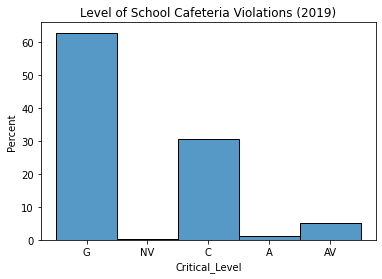

In [11]:
#Distribution of violations by level of violation
sns.histplot(inspections_with_index['Critical_Level'], stat='percent')
plt.title('Level of School Cafeteria Violations (2019)')
plt.show()

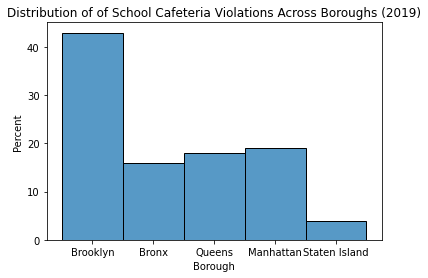

In [12]:
#Distribution of all violations by borough
sns.histplot(inspections_with_index['Borough'], stat='percent')
plt.title('Distribution of of School Cafeteria Violations Across Boroughs (2019)')
plt.show()

In [14]:
#Schools with the most violations in 2019
violation_count_school=inspections_with_index.groupby('SchoolName').count()
violation_count_school.sort_values(by= 'Record_ID', ascending=False).head(10)

,Record_ID,Borough,Building,Street,Address_Line_1,City,ZipCode,Last_Inspection_Date,Permittee,Inspection_Date,...,Violation_Description,Critical_Level,LATITUDE,LONGITUDE,COMMUNITYBOARD,COUNCILDISTRICT,CENSUSTRACT,BIN,BBL,NTA
SchoolName,,,,,,,,,,,,,,,,,,,,,
NESIVOS BAIS YAAKOV,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
MERKAZ HATORAH OF BELLE HARBOR,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
YESHIVA MEOR HATALMUD,34,34,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34
TALMUDICAL SCHOOL OF BROOKLYN,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
YESHIVA TORAH VODAATH SCHOOL,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
YESHIVAS NOVOMINSK,23,23,23,23,23,23,23,23,23,23,...,22,22,23,23,23,23,23,23,23,23
TALMUD TORAH IMREI CHAIM,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
BAIS SARAH SCHOOL,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
CENTRAL U.T.A.,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


In [15]:
#Most common violations in 2019
violation_count_type=inspections_with_index.groupby('Code').count()
violation_count_type.sort_values(by= 'Record_ID', ascending=False).head(10)

,Record_ID,Borough,Building,Street,Address_Line_1,City,ZipCode,Last_Inspection_Date,Permittee,Inspection_Date,Violation_Description,Critical_Level,LATITUDE,LONGITUDE,COMMUNITYBOARD,COUNCILDISTRICT,CENSUSTRACT,BIN,BBL,NTA
Code,,,,,,,,,,,,,,,,,,,,
10F,1974,1974,1974,1974,1974,1974,1974,1974,1974,1974,1974,1974,1974,1974,1974,1974,1974,1968,1974,1974
08A,992,992,992,992,992,992,992,992,992,992,992,992,992,992,992,992,992,991,992,992
10B,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,830,831,831
04L,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,797,798,798
04N,260,260,260,260,260,260,260,260,260,260,260,260,260,260,260,260,260,259,260,260
06C,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227
22C,225,225,225,225,225,225,225,225,225,225,225,225,225,225,225,225,225,224,225,225
04A,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176
04M,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155


In [16]:
critical_violations = inspections_with_index.query('Critical_Level =="C"')

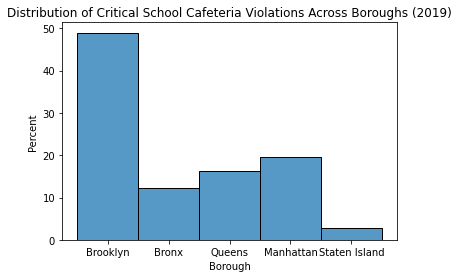

In [17]:
#Distributuion of critical violations by school type
sns.histplot(critical_violations['Borough'], stat='percent')
plt.title('Distribution of Critical School Cafeteria Violations Across Boroughs (2019)')
plt.show()

In [18]:
#Most common critical violations in 2019
violation_count_type=critical_violations.groupby('Code').count()
violation_count_type.sort_values(by= 'Record_ID', ascending=False).head(10)

,Record_ID,Borough,Building,Street,Address_Line_1,City,ZipCode,Last_Inspection_Date,Permittee,Inspection_Date,Violation_Description,Critical_Level,LATITUDE,LONGITUDE,COMMUNITYBOARD,COUNCILDISTRICT,CENSUSTRACT,BIN,BBL,NTA
Code,,,,,,,,,,,,,,,,,,,,
04L,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,797,798,798
04N,260,260,260,260,260,260,260,260,260,260,260,260,260,260,260,260,260,259,260,260
06C,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227
04A,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176,176
04M,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155
02G,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143,142,143,143
06D,142,142,142,142,142,142,142,142,142,142,142,142,142,142,142,142,142,142,142,142
04J,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83
02B,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65


In [19]:
#Turning critical violations into geodataframe
geoms_violations = gpd.points_from_xy(critical_violations['LONGITUDE'],critical_violations['LATITUDE'])
critical_violations_new = gpd.GeoDataFrame(critical_violations, geometry =geoms_violations)
critical_violations_new.crs= 4326

In [20]:
#Turning all violations into geodataframe
geoms_violations_all = gpd.points_from_xy(inspections_with_index['LONGITUDE'],inspections_with_index['LATITUDE'])
all_violations_new= gpd.GeoDataFrame(inspections_with_index, geometry =geoms_violations_all)
all_violations_new.crs=4326

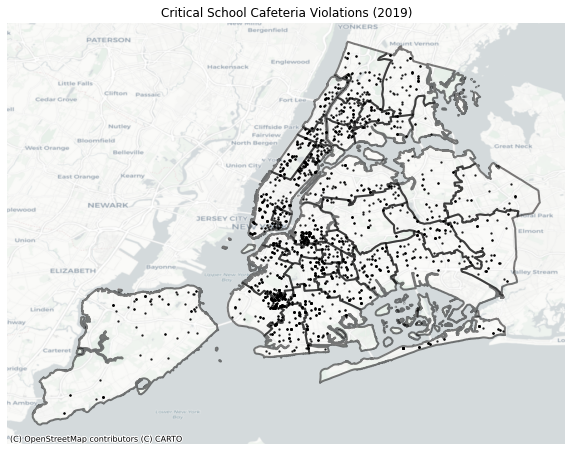

In [21]:
#Mapping critical violations
fig, ax = plt.subplots(figsize=(10, 10))
critical_violations_new.plot (alpha=0.7, color='black', markersize=2, ax=ax)
school_districts.plot(alpha=0.5, edgecolor='black', facecolor='none', linewidth=2, ax=ax)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=4326)
plt.title('Critical School Cafeteria Violations (2019)')
ax.axis('off');

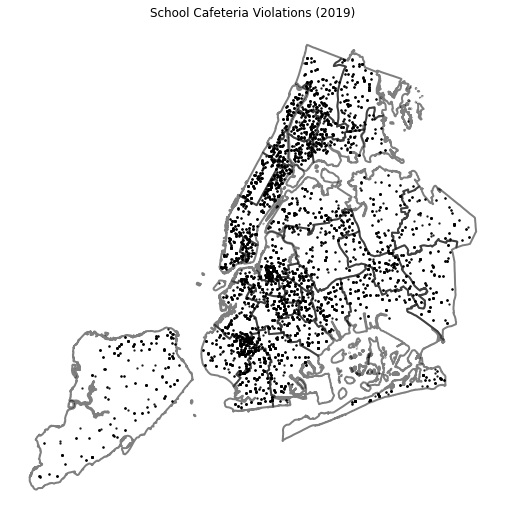

In [22]:
#Mapping all cafeteria violations
fig, ax = plt.subplots(figsize=(9, 9))
school_districts.plot(alpha=0.5, edgecolor='black', facecolor='none', linewidth=2, ax=ax)
all_violations_new.plot (alpha=0.7, color='black', markersize=2, ax=ax)
plt.title('School Cafeteria Violations (2019)')
ax.axis('off');

In [23]:
#Spatial join of violations to school districts (school district was not included in cafeteria inspections dataset)
merged= gpd.sjoin(all_violations_new, school_districts, how='left', predicate='within')

In [24]:
#Calculating how many schools within each district have violations
schools_per_district=merged.drop_duplicates(subset=['Building'])
schools_per_district_count=schools_per_district.groupby('shape_leng').count()
schools_per_district_count_new=schools_per_district_count['Record_ID']

In [25]:
#Join school count to school districts geography
schools_per_district_count_new_join=schools_per_district_count_new.reset_index()
school_count_join= pd.merge(school_districts, schools_per_district_count_new_join, on='shape_leng', how='left')

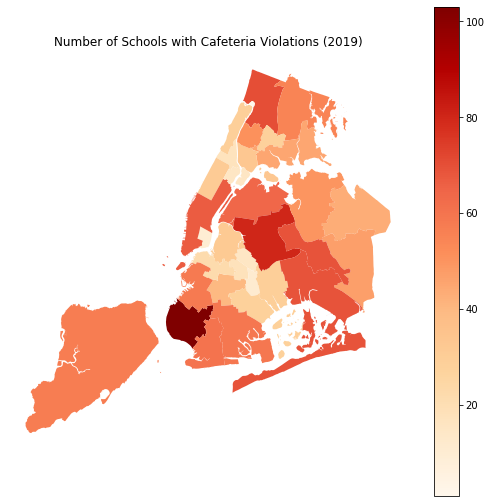

In [26]:
#Mapping number of schools with violations per school district
fig, ax = plt.subplots(figsize=(9, 9))
school_count_join.plot (column='Record_ID', ax=ax, legend=True, cmap='OrRd')
plt.title('Number of Schools with Cafeteria Violations (2019)')
ax.axis('off');

In [27]:
#Normalizing the number of violations within each district 
#by number of schools that have violations per disctrict
violations_count_district= merged.groupby('shape_leng').count()
violations_count_district=violations_count_district['Building']
per_school=violations_count_district/schools_per_district_count_new

In [28]:
#Joining normalized number of violations to school district geography
per_school=per_school.reset_index()
per_school_join= pd.merge(school_districts, per_school, on='shape_leng', how='left')

In [29]:
per_school_join.columns

Index(['school_dis', 'shape_area', 'shape_leng', 'geometry', 0], dtype='object')

In [31]:
per_school_join_final= per_school_join.rename(columns = {0:'per_school'})

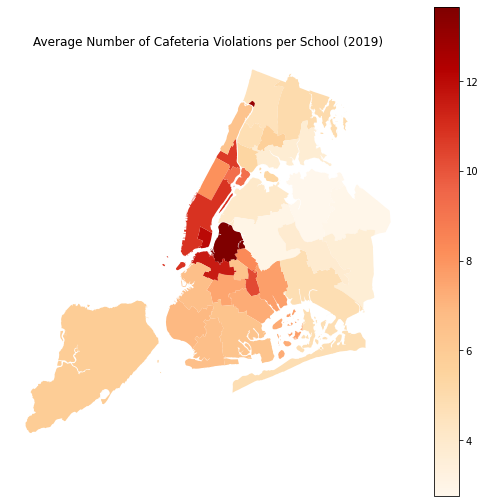

In [32]:
#Mapping average number of violations in schools that have violations (within each district)
fig, ax = plt.subplots(figsize=(9, 9))
per_school_join_final.plot (column='per_school', ax=ax, legend=True, cmap='OrRd')
plt.title('Average Number of Cafeteria Violations per School (2019)')
ax.axis('off');

In [33]:
def rasterize(gdf, grid, aggfunc="count", column=None, plot=True):
    merged= gpd.sjoin(gdf, school_districts, how='left', predicate='within').copy()
    if aggfunc == "count":
        column = 'count'
        output_col = column 
        merged[column]=1
    else:
        output_col = column + "_" + aggfunc
    dissolved= merged.dissolve(by="index_right", aggfunc=aggfunc)[[column]]
    dissolved.columns=[output_col]
    school_districts.loc[dissolved.index, output_col]=dissolved[output_col].values
    if plot:
        ax=school_districts.plot(column=output_col, figsize=(12, 8),edgecolor="white", legend=True, cmap='magma_r')
        ax.axis('off')
        cx.add_basemap (ax, crs=gdf.crs,source= cx.providers.CartoDB.Positron)
        plt.show()
    return grid

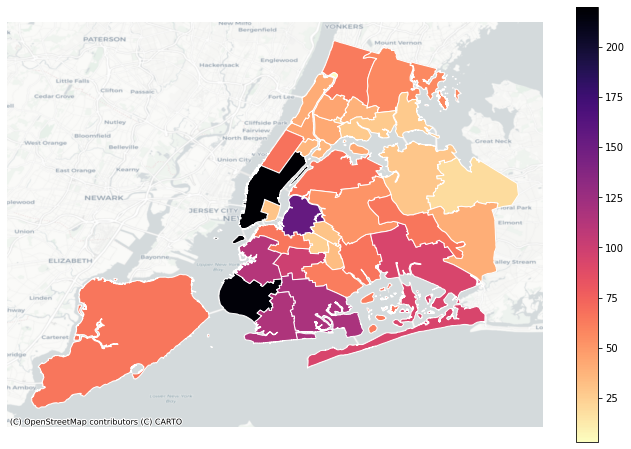

In [34]:
#Mapping Count of critical violations per school district
r= rasterize(critical_violations_new, school_districts, aggfunc="count")

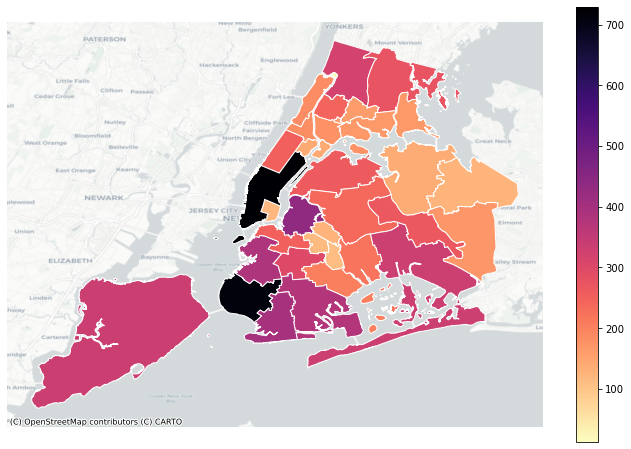

In [35]:
#Mapping count of all violations per school district
r2= rasterize(all_violations_new, school_districts, aggfunc="count")

### II. Community Gardens

In [36]:
gardens = pd.read_csv("/Users/juliekerisel/Desktop/info615/final_data/schools_community_gardens.csv")

In [37]:
schools = pd.read_csv("/Users/juliekerisel/Desktop/info615/final_data/nyc_schools.csv")
schools= schools.drop_duplicates(subset=['system_cod'])
schools= schools.rename(columns = {'Administra':'school_dis', 'system_cod':'School_ID', 'Location_1':'School_Type', 'location_t':'School_Type2'})

In [38]:
#Turning schools into geodataframe
geoms_schools = gpd.points_from_xy(schools['LONGITUDE'],schools['LATITUDE'])
new_schools= gpd.GeoDataFrame(schools, geometry =geoms_schools)
new_schools.crs=4326

In [39]:
#change column name for join
gardens_ready= gardens.rename(columns = {'boro_code':'LOC_CODE'})

In [40]:
#create new column to indicate which schools have garden 
#1:school has garden, 0/NA: school does not have garden
gardens_ready['garden']=""

In [41]:
gardens_ready['garden']="1"

In [42]:
#join schools to gardens 
schools_garden= pd.merge(new_schools, gardens_ready, on='LOC_CODE', how='left')

In [43]:
schools_garden= schools_garden.drop_duplicates(subset=['LOC_CODE'])

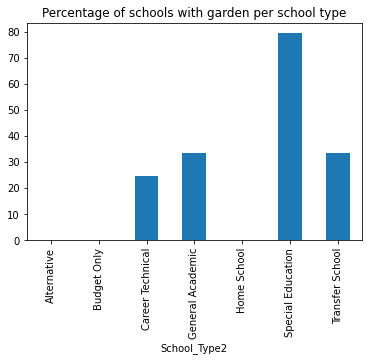

In [44]:
#Percentage of schools with garden by School Type 2
schools_count_type2=schools_garden.groupby('School_Type2').count()
schools_count_type2=schools_count_type2['School_ID']
garden_count_type2= schools_garden.groupby('School_Type2').count()['garden']
boro_garden_count=garden_count_type2/schools_count_type2*100
boro_garden_count.plot.bar(rot=0)
plt.title('Percentage of schools with garden per school type')
plt.xticks(rotation=90)
plt.show()

In [45]:
schools_count_type2

School_Type2
Alternative             6
Budget Only             1
Career Technical       53
General Academic     1941
Home School             1
Special Education      63
Transfer School        60
Name: School_ID, dtype: int64

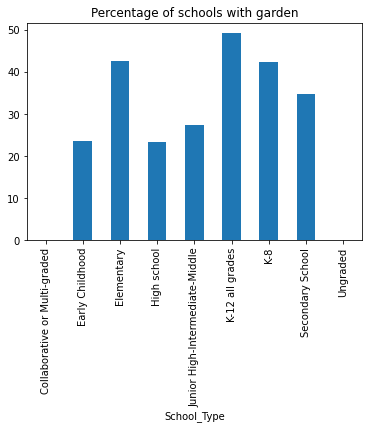

In [46]:
#Percentage of schools with garden by school type
schools_type_count=schools_garden.groupby('School_Type').count()
schools_type_count=schools_type_count['School_ID']
garden_school_type=schools_garden.groupby('School_Type').count()['garden']
um=garden_school_type/schools_type_count*100
um.plot.bar(rot=0)
plt.xticks(rotation=90)
plt.title('Percentage of schools with garden')
plt.show()

In [47]:
schools_type_count

School_Type
Collaborative or Multi-graded        1
Early Childhood                     17
Elementary                         778
High school                        533
Junior High-Intermediate-Middle    383
K-12 all grades                     67
K-8                                227
Secondary School                   115
Ungraded                             4
Name: School_ID, dtype: int64

In [48]:
schools_garden['garden'] = schools_garden['garden'].fillna(0)

In [49]:
schools_w_garden= schools_garden.query("garden == '1'")

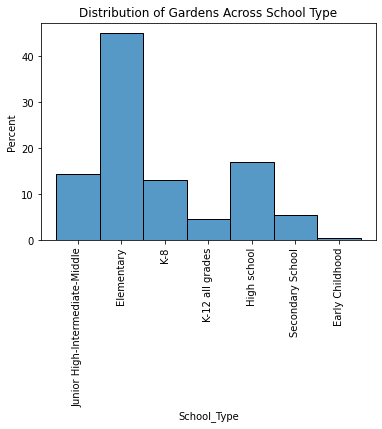

In [50]:
sns.histplot(schools_w_garden['School_Type'], stat='percent')
plt.title('Distribution of Gardens Across School Type')
plt.xticks(rotation=90)
plt.show()

In [51]:
schools_garden.crs=4326

In [52]:
boros.crs=4326

In [53]:
#Spatial join of schools to borough (borough was missing from school dataset)
boro_schools_join= gpd.sjoin(schools_garden, boros, how='left', predicate='within')

In [54]:
boro_schools_join.groupby('shape_leng').count()

,School_ID,location_c,location_n,BEDS,Managed_by,School_Type2,School_Type,Grades_tex,Grades_fin,open_date,...,NUMBER,ADDRESS,BOROUGH,STATE,ZIP,garden,index_right,boro_code,boro_name,shape_area
shape_leng,,,,,,,,,,,,,,,,,,,,,
325924.002252,84,84,84,84,84,84,84,84,81,84,...,26,26,26,26,26,84,84,84,84,84
359993.127161,427,427,427,427,427,427,427,411,416,427,...,142,142,142,142,141,427,427,427,427,427
463868.935588,534,534,534,534,534,534,534,507,503,534,...,163,163,163,163,163,534,534,534,534,534
728195.194837,675,675,675,675,675,675,675,647,650,675,...,257,257,257,257,257,675,675,675,675,675
900269.281914,405,405,405,405,405,405,405,395,391,405,...,146,146,146,146,146,405,405,405,405,405


In [55]:
boros

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1.0,Manhattan,6.366208e+08,359993.127161,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
1,2.0,Bronx,1.187194e+09,463868.935588,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,3.0,Brooklyn,1.934174e+09,728195.194837,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
3,5.0,Staten Island,1.623631e+09,325924.002252,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
4,4.0,Queens,3.040206e+09,900269.281914,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


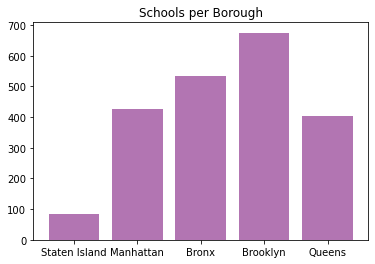

In [56]:
x=[84, 427, 534, 675, 405]
labels=('Staten Island', 'Manhattan', 'Bronx', 'Brooklyn', 'Queens')
x_pos = np.arange(len(boros))
plt.bar(x_pos, x, color = (0.5,0.1,0.5,0.6))
plt.xticks(x_pos, labels)
plt.title('Schools per Borough')
plt.show()

In [57]:
#Spatial join of schools to borough (borough was missing from school dataset)
boro_garden_join= gpd.sjoin(schools_w_garden, boros, how='left', predicate='within')

In [58]:
boro_garden_join.groupby('shape_leng').count()

,School_ID,location_c,location_n,BEDS,Managed_by,School_Type2,School_Type,Grades_tex,Grades_fin,open_date,...,NUMBER,ADDRESS,BOROUGH,STATE,ZIP,garden,index_right,boro_code,boro_name,shape_area
shape_leng,,,,,,,,,,,,,,,,,,,,,
325924.002252,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
359993.127161,142,142,142,142,142,142,142,142,142,142,...,142,142,142,142,141,142,142,142,142,142
463868.935588,163,163,163,163,163,163,163,162,163,163,...,163,163,163,163,163,163,163,163,163,163
728195.194837,257,257,257,257,257,257,257,256,257,257,...,257,257,257,257,257,257,257,257,257,257
900269.281914,146,146,146,146,146,146,146,146,146,146,...,146,146,146,146,146,146,146,146,146,146


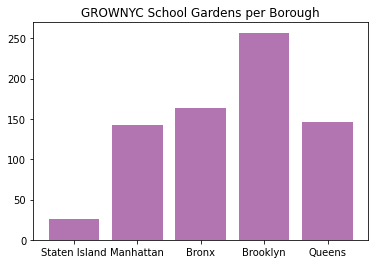

In [59]:
x=[26, 142, 163, 257, 146]
labels=('Staten Island', 'Manhattan', 'Bronx', 'Brooklyn', 'Queens')
x_pos = np.arange(len(boros))
plt.bar(x_pos, x, color = (0.5,0.1,0.5,0.6))
plt.xticks(x_pos, labels)
plt.title('GROWNYC School Gardens per Borough')
plt.show()

In [60]:
#Calculating percentage of schools that have a garden by borough
x=[84, 427, 534, 675, 405]
y=[26, 142, 163, 257, 146]
x=np.array(x)
y=np.array(y)
z=y/x*100
schools_w_garden_percent=z.tolist()

In [61]:
schools_w_garden_percent

[30.952380952380953,
 33.25526932084309,
 30.52434456928839,
 38.074074074074076,
 36.04938271604938]

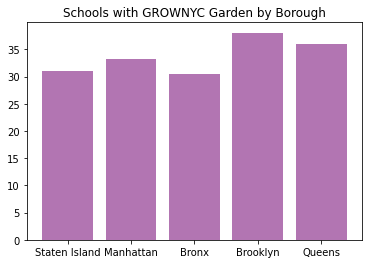

In [62]:
x=[30.952380952380953,
 33.25526932084309,
 30.52434456928839,
 38.074074074074076,
 36.04938271604938]
boros=('Staten Island', 'Manhattan', 'Bronx', 'Brooklyn', 'Queens')
x_pos = np.arange(len(boros))
plt.bar(x_pos, x, color = (0.5,0.1,0.5,0.6))
plt.xticks(x_pos, boros)
plt.title('Schools with GROWNYC Garden by Borough')
plt.show()

In [63]:
df=schools_garden

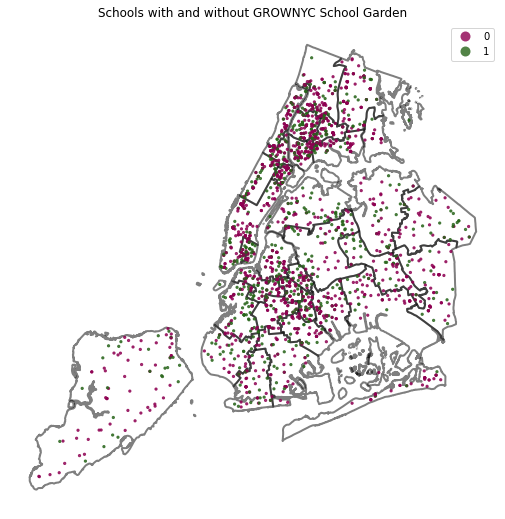

In [64]:
#Mapping schools with and without gardens
fig, ax = plt.subplots(figsize=(9, 9))
school_districts.plot(alpha=0.5,edgecolor='black', facecolor='none', linewidth=2, ax=ax)
df.plot (alpha=0.8, markersize=5, ax=ax, column='garden', cmap ='PiYG', legend=True)
plt.title('Schools with and without GROWNYC School Garden')
ax.axis('off');

In [65]:
df.garden = df.garden.astype(str)

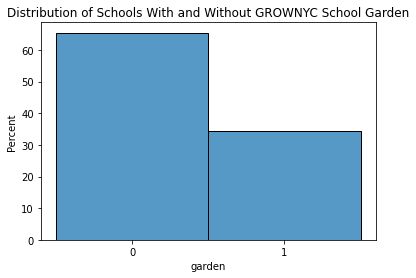

In [66]:
#Schools with and without garden in all of NYC
sns.histplot(df['garden'], stat='percent')
plt.title('Distribution of Schools With and Without GROWNYC School Garden')
plt.show()

#### Mapping percentage of schools with garden per school district

In [67]:
#Number of schools per district
total_schools= df.groupby('school_dis').count()
total_schools_per_district=total_schools['School_ID']

In [68]:
#Garden count per school district
garden_count= schools_w_garden.groupby('school_dis').count()
garden_count= garden_count['School_ID']

In [69]:
#Percentage of schools that have a garden per district 
percentage=garden_count/total_schools_per_district*100

In [70]:
#Joining percentage of school with garden to school district geography
percentage=percentage.reset_index()
percent_join= pd.merge(school_districts, percentage, on='school_dis', how='left')

In [71]:
percent_join.columns

Index(['school_dis', 'shape_area', 'shape_leng', 'geometry', 'count',
       'School_ID'],
      dtype='object')

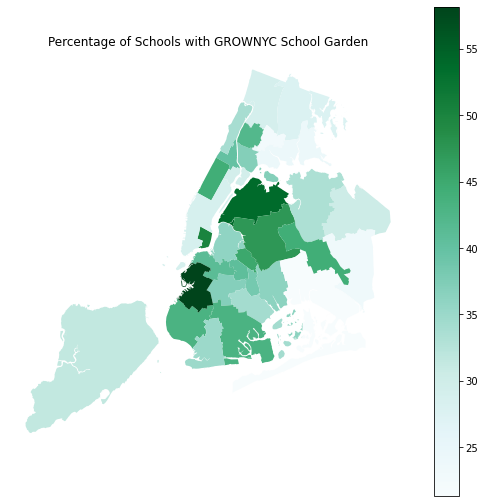

In [72]:
fig, ax = plt.subplots(figsize=(9, 9))
percent_join.plot (column='School_ID', ax=ax, cmap='BuGn',legend=True)
plt.title('Percentage of Schools with GROWNYC School Garden')
ax.axis('off');

### III. Hot Spot Analysis of Gardens

In [73]:
garden_clusters = schools_w_garden.to_crs(6933)

In [74]:
def make_grid(gdf, n_cells):
    gdf=gdf.copy()
    xmin, ymin, xmax, ymax=gdf.total_bounds
    cell_size=(xmax-xmin)/n_cells
    grid_cells=[]
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1=x0-cell_size
            y1=y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1) )
    grid=gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf.crs)
    return grid

In [105]:
grid_gardens=make_grid(garden_clusters, n_cells=75)

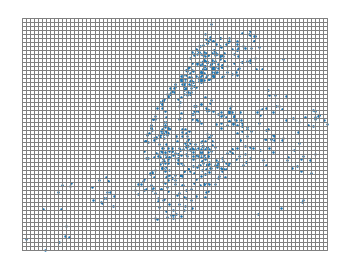

In [106]:
ax= garden_clusters.plot(markersize=2,  figsize=(6, 6))
grid_gardens.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1)
ax.axis('off');

In [107]:
school_districts_new= school_districts.to_crs(6933)

In [108]:
#Rasterize function with school district layer

def rasterize2(gdf, grid, aggfunc="count", column=None, plot=True):
    merged= gpd.sjoin(gdf, grid, how='left', predicate='within').copy()
    if aggfunc == "count":
        column = 'count'
        output_col = column 
        merged[column]=1
    else:
        output_col = column + "_" + aggfunc
    dissolved= merged.dissolve(by="index_right", aggfunc=aggfunc)[[column]]
    dissolved.columns=[output_col]
    grid.loc[dissolved.index, output_col]=dissolved[output_col].values
    if plot:
        ax=grid.plot(column=output_col, figsize=(12, 8), edgecolor="grey", legend=True, cmap='cool')
        ax.axis('off')
        cx.add_basemap (ax, crs=gdf.crs,source= cx.providers.CartoDB.Positron)
        school_districts_new.plot(alpha=0.5, edgecolor='black', facecolor='none',linewidth=2, ax=ax)
        plt.show()
    return grid

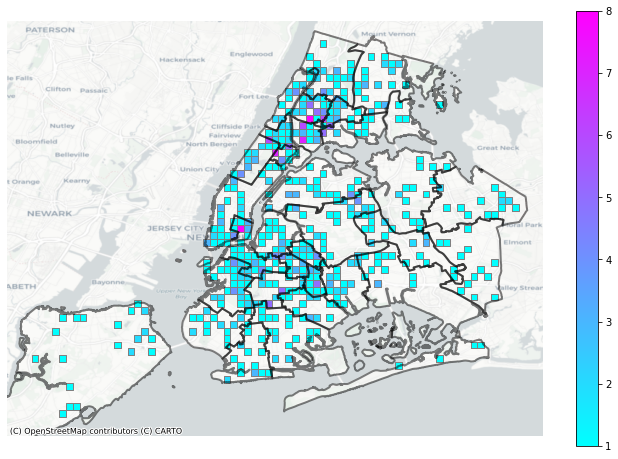

In [109]:
r3= rasterize2(garden_clusters, grid_gardens, aggfunc="count")

In [110]:
r3=r3.dropna(subset=['count'])

In [111]:
w1= weights.Queen.from_dataframe(r3)

/Users/juliekerisel/opt/miniconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/weights.py:167: UserWarning: There are 41 disconnected observations 
  Island ids: 0, 1, 3, 4, 6, 10, 11, 12, 18, 20, 45, 118, 142, 143, 149, 182, 251, 298, 299, 372, 377, 380, 381, 385, 395, 398, 401, 403, 408, 411, 422, 424, 425, 428, 430, 431, 439, 442, 446, 449, 450
  warnings.warn("There are %d disconnected observations" % ni + ' \n '


In [112]:
w1.transform= 'R'

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 118, ' is an island (no neighbors)')
('WARNING: ', 142, ' is an island (no neighbors)')
('WARNING: ', 143, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 182, ' is an island (no neighbors)')
('WARNING: ', 251, ' is an island (no neighbors)')
('WARNING: ', 298, ' is an island (no neighbors)')
('WARNING: ', 299, ' is an island (no neighbors)')
('WARNING: ', 372, ' is an island (no neighbors

In [113]:
local_moran= esda.moran.Moran_Local(r3['count'], w1)

In [114]:
r3['local_moran_Is']=local_moran.Is

/Users/juliekerisel/opt/miniconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [115]:
r3['local_moran_p_value'] = local_moran.p_sim

/Users/juliekerisel/opt/miniconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [116]:
r3['local_moran_quadrant']=local_moran.q

/Users/juliekerisel/opt/miniconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [117]:
alpha=0.05
hotspots = r3.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = r3.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
doughnuts = r3.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
diamonds = r3.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

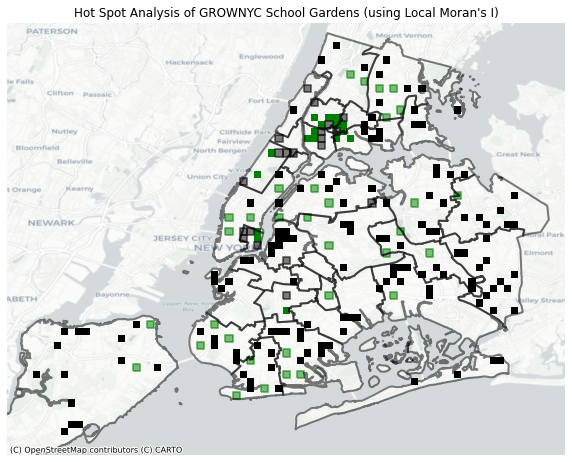

In [118]:
fig, ax= plt.subplots(figsize=(10,10))
r3.plot(ax=ax, facecolor='none', alpha=0)
hotspots.plot(color='green', ax=ax, label='Hot Spot')
coldspots.plot(color='black', alpha=0.5, edgecolor='black', linewidth=2, ax=ax, label='Cold Spot')
doughnuts.plot(color='black',ax=ax, label='Doughnuts')
diamonds.plot(color='green', alpha=0.5, edgecolor='green', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=6933)
school_districts_new.plot(alpha=0.5, edgecolor='black', facecolor='none',linewidth=2, ax=ax)
ax.axis('off')
plt.title("Hot Spot Analysis of GROWNYC School Gardens (using Local Moran's I)");
plt.show()

### IV. Hot Spot Analysis of Cafeteria Violations

In [119]:
caf_clusters= critical_violations_new[critical_violations_new["Borough"].str.contains("Staten Island") == False]

In [120]:
caf_clusters=critical_violations_new.to_crs(6933)

In [121]:
grid_caf=make_grid(caf_clusters, n_cells=75)

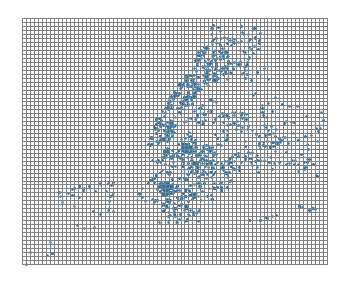

In [122]:
ax= caf_clusters.plot(markersize=2,  figsize=(6, 6))
grid_caf.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1)
ax.axis('off');

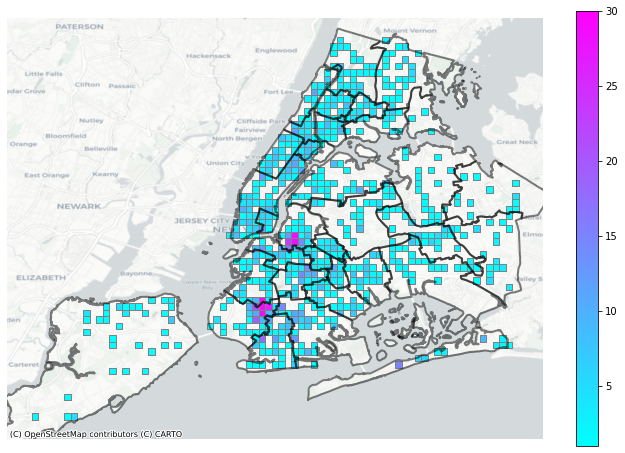

In [123]:
r4= rasterize2(caf_clusters, grid_caf, aggfunc="count")

In [124]:
r4=r4.dropna(subset=['count'])

In [125]:
w2= weights.Queen.from_dataframe(r4)

/Users/juliekerisel/opt/miniconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/weights.py:167: UserWarning: There are 40 disconnected observations 
  Island ids: 0, 2, 4, 11, 14, 16, 20, 22, 24, 25, 26, 27, 33, 283, 447, 501, 506, 517, 546, 558, 567, 575, 576, 578, 585, 586, 594, 596, 602, 605, 606, 607, 609, 610, 611, 612, 616, 617, 628, 635
  warnings.warn("There are %d disconnected observations" % ni + ' \n '


In [126]:
w2.transform= 'R'

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 283, ' is an island (no neighbors)')
('WARNING: ', 447, ' is an island (no neighbors)')
('WARNING: ', 501, ' is an island (no neighbors)')
('WARNING: ', 506, ' is an island (no neighbors)')
('WARNING: ', 517, ' is an island (no neighbors)')
('WARNING: ', 546, ' is an island (no neighbors)')
('WARNING: ', 558, ' is an island (no neighbors

In [127]:
local_moran= esda.moran.Moran_Local(r4['count'], w2)

In [128]:
r4['local_moran_Is']=local_moran.Is

/Users/juliekerisel/opt/miniconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [129]:
r4['local_moran_p_value'] = local_moran.p_sim

/Users/juliekerisel/opt/miniconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [130]:
r4['local_moran_quadrant']=local_moran.q

/Users/juliekerisel/opt/miniconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [131]:
alpha=0.05
hotspots_caf = r4.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_caf = r4.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
doughnuts_caf = r4.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
diamonds_caf = r4.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

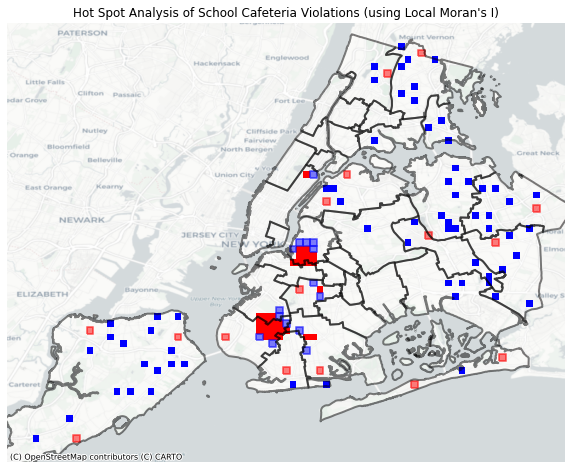

In [132]:
fig, ax= plt.subplots(figsize=(10,10))
r4.plot(ax=ax, facecolor='none', alpha=0)
hotspots_caf.plot(color='red', ax=ax, label='Hot Spot')
coldspots_caf.plot(color='blue', alpha=0.5, edgecolor='blue', linewidth=2, ax=ax, label='Cold Spot')
doughnuts_caf.plot(color='blue',ax=ax, label='Doughnuts')
diamonds_caf.plot(color='red', alpha=0.5, edgecolor='red', linewidth=2, ax=ax, label='Diamonds')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=6933)
school_districts_new.plot(alpha=0.5, edgecolor='black', facecolor='none',linewidth=2, ax=ax)
ax.axis('off')
plt.title("Hot Spot Analysis of School Cafeteria Violations (using Local Moran's I)");